In this version(1.6): 
- Text processing
    - punctuations, insert space to the right only; done
    - inverse transform; done
- calculate perplexity during training from loss function.; done
- Penn Treebank http://www.nltk.org/howto/corpus.html. 

In the upcoming versions:

- apply to other languages
    - Russian
    - Arabic
    - French
- apply this network for char-level language modeling.
- label smoothing; Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, and Zbigniew Wojna.
Rethinking the inception architecture for computer vision. CoRR, abs/1512.00567, 2015.


- Training, fix number of token in a single epoch and pass the state of an epoch to the next epoch



-  paper RECURRENT NEURAL NETWORK REGULARIZATION,2015
- https://arxiv.org/pdf/1308.0850.pdf

For restoring previous check-point, I was forced to define the whole model in this notebook, rather that importing it from an external .py module.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from lib.dictionarymd import Dictionary
from lib.textprocessingmd import convert_text,restore_text
from lib.fileoperationmd import getFilesFromPath,readTxtFromFile,log,clearLog

[nltk_data] Downloading package stopwords to /home/zein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from hyper import HyperParameters
hp=HyperParameters()

In [3]:
def loadData(path,fname):
    text=readTxtFromFile(path,fname)
    return [line for line in text.split('\n') if len(line)>10]

In [4]:
# --- Load articles - form dictionary - load dictionary
hp.DATAPATH='./data/ptb'
fname_train='ptb.train.txt'
filenames=getFilesFromPath(hp.DATAPATH)
text=readTxtFromFile(hp.DATAPATH,fname_train)

dictionary=Dictionary()
dictionary.make_vocab(text,hp.VOCPATH,hp.VOCFILE)

In [5]:
hp.DATAPATH='./data/ptb/'
fname_train='ptb.train.txt'
fname_test ='ptb.test.txt'
fname_valid='ptb.valid.txt'

dictionary=Dictionary()
dictionary.load_vocab(hp.VOCPATH,hp.VOCFILE)
dataset=[]

trainset=loadData(hp.DATAPATH,fname_train)

# Train

In [6]:
import tensorflow as tf
import numpy as np
from RNN_LSTM_LM import LSTMModel
from helpers import batches_generator
from helpers import Beam
from helpers import beam_search,getBestCandidate

clearLog(hp.LOGPATH,hp.LOGFILE)
tf.reset_default_graph()

/home/zein/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
model = LSTMModel(vocabulary_size=len(dictionary.word2idx), n_tags=len(dictionary.word2idx), embedding_dim=hp.embedding_dim,
                  n_hidden_rnn=hp.n_hidden_rnn, PAD_index=dictionary.word2idx['<PAD>'])
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#model_checkpoint = './model.chkpt'
saver = tf.train.Saver()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
def compute_perplexity(sess,model):
    test="The pair are facing lengthy bans for the missed tests, including one on the eve of last year's Athens Olympics."
    vec=[test]
    for x_batch, y_batch, lengths in batches_generator(hp.batch_size, vec,dictionary):
        per=model.calculatePerplexity(sess,x_batch,y_batch, lengths)
    return np.exp(per)
perplexity=[]

In [9]:
hp.batch_size=64

ُEboch 1/50.batch 105/654 
Epoch 0: <start> the meaning of life is a $ N a year earlier the new york-based stock exchange commission 's N N N stake in N million francs N cents a $ of N million or N N to yield $ N million or $ N million or $ N a $ N billion loss from N N in the year-earlier quarter from $ $ $ $ N billion or a share from the year earlier a share on N N in N N N N one week in N million shares in september N N N in the third period to $ $ a year of N N to N million francs from the N N of a $ N N cents in the third period to the third of N N and N N of the third period in september and a year earlier the third quarter of $ $ a share in the third; perplexity: 261.8497619628906


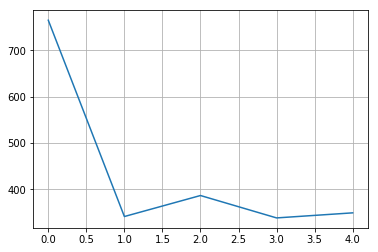

In [ ]:
from IPython.display import clear_output
test=[]
learning_rate=hp.learning_rate
print('Start training... \n')
results=""
start=0
for epoch in range(start,hp.n_epochs):
    newPerp=compute_perplexity(sess,model)
    #perplexity.append(newPerp)
    newc=getBestCandidate(sess,model,150,"the meaning of life is",dictionary)
    results="\nEpoch {}: {}; perplexity: {}".format(epoch,newc, newPerp)
    log(hp.LOGPATH,hp.LOGFILE,results)
    # For each epoch evaluate the model on train and validation data
    #print('-' * 20 + ' Epoch {} '.format(epoch+1) + 'of {} '.format(hp.n_epochs) + '-' * 20+results)
    
    counter=0
    # Train the model
    for x_batch, y_batch, lengths in batches_generator(hp.batch_size, trainset,dictionary):
        
        clear_output(wait=True)
        
        counter=counter+1
        print("ُEboch {}/{}.batch {}/{} {}".format(epoch+1,hp.n_epochs,counter,len(trainset)//hp.batch_size,results))
        plt.plot(perplexity)
        plt.grid()
        plt.show()
        loss=model.train_on_batch(sess, x_batch, y_batch, lengths, learning_rate, hp.dropout_keep_probability)
        if counter%100==0:
            perplexity.append(loss)
    # Decaying the learning rate
    saver.save(sess, hp.MODEL_CHKPNT_PATH,global_step=epoch)
    learning_rate = learning_rate / 1.61#hp.learning_rate_decay
    
print('...training finished.')

In [10]:
%time
# Generate text of 1000 words
full="""The pair are facing lengthy bans for the missed tests, including one on the eve of last year's Athens Olympics. 
They were set to learn their fate by the end of February, but late evidence from them has pushed the date back. "A decision is now expected by around mid-March," said one of their lawyers, Michalis Dimitrakopoulos."""
print(restore_text(getBestCandidate(sess,model,1000,'I',dictionary)))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.2 µs
<START> I have been a lot of <UNK> and he was be a great <UNK> <UNK> <UNK> " 
>>>> The " I don' I think I think it is <UNK> " he is not a great in a lot of <UNK> " he was a <UNK> " 
>>>> 
>>>> " I have to <UNK> <UNK> " 
>>>> 
>>>> 
>>>> " 
>>>> 
>>>> " I am be a game and <UNK> " I don' I can be <UNK> <UNK> <UNK> <UNK> and <UNK> " I have to play <UNK> and <UNK> and <UNK> and <UNK> <UNK> " I am <UNK> <UNK> and it is <UNK> <UNK> <UNK> and I have <UNK> " he is not a lot and <UNK> <UNK> " 
>>>> The " We are a great in <UNK> " he said. " I am be in his <UNK> and <UNK> " I have <UNK> <UNK> <UNK> and it is <UNK> and it was <UNK> and it is to <UNK> " I don' I can be <UNK> " 
>>>> The " 
>>>> " I have been <UNK> and I am <UNK> " he was be <UNK> " I have to be a <UNK> <UNK> and I have been to be a lot of a final and in his first Nations " 
>>>> " 
>>>> 
>>>> " We have been a lot of his " I have to be <UNK> and a lot of <UNK> " he is 

In [32]:
#todo

# version2
# output
# normalize probabilities
# Evaluation

# char-level

# larger network

# Russian
# Arabic 
# French

# paper RECURRENT NEURAL NETWORK REGULARIZATION,2015